In [1]:
import pandas as pd
import numpy as np
import os

###############################################
# Reshape World Population data to long format
###############################################
def reshape_population_data(pop_path='../raw_data/world_population.csv', output_path='../processed_data/population_long_format.csv'):
    """
    Load world population data and reshape from wide format (years as columns)
    to long format (one row per country-year).
    """
    
    # Load the data
    df = pd.read_csv(pop_path)
    
    # Identify year columns (those that end with " Population")
    year_cols = [col for col in df.columns if 'Population' in col and col != 'World Population Percentage']
    
    # Extract year from column name (e.g., "2022 Population" -> 2022)
    year_mapping = {col: int(col.split()[0]) for col in year_cols}
    year_cols_sorted = sorted(year_cols, key=lambda x: year_mapping[x], reverse=True)
    
    # Identify non-year columns (identifiers and metadata)
    id_cols = [col for col in df.columns if col not in year_cols]
    
    # Reshape from wide to long format using pd.melt()
    df_long = pd.melt(df, 
                      id_vars=id_cols, 
                      value_vars=year_cols_sorted,
                      var_name='Year_Column', 
                      value_name='Population')
    
    # Extract year from the Year_Column and drop the column
    df_long['Year'] = df_long['Year_Column'].apply(lambda x: int(x.split()[0]))
    df_long = df_long.drop('Year_Column', axis=1)
    
    # Sort by country and year
    df_long = df_long.sort_values(['Country/Territory', 'Year']).reset_index(drop=True)
    
    # Save the reshaped data
    output_dir = '../processed_data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df_long.to_csv(output_path, index=False)
    
    return df_long


# Run the reshape function
df_pop_long = reshape_population_data()

In [2]:
import pandas as pd
import numpy as np
import os


###############################################
# Merge population and World Bank data
###############################################
def merge_population_and_worldbank(pop_long_path='../processed_data/population_long_format.csv', 
                                   wb_path='../raw_data/WorldBank.csv'):
    """
    Merge long-format population data with World Bank data.
    
    Returns:
        df_merged : DataFrame with all population and World Bank indicators by country-year
    """
    
    # Load long-format population and World Bank data
    df_pop = pd.read_csv(pop_long_path)
    df_wb = pd.read_csv(wb_path)
    
    # Merge population with World Bank data on Country Code and Year
    df_merged = df_pop.merge(
        df_wb,
        left_on=['CCA3', 'Year'],
        right_on=['Country Code', 'Year'],
        how='inner'
    )
    
    # Reset index
    df_merged = df_merged.reset_index(drop=True)
    
    print(f"Merged data shape: {df_merged.shape}")
    print(f"Year range: {df_merged['Year'].min()} - {df_merged['Year'].max()}")
    print(f"Number of countries: {df_merged['CCA3'].nunique()}")
    print(f"Number of country-year observations: {len(df_merged)}\n")
    
    # Save merged data
    output_dir = '../processed_data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df_merged.to_csv(os.path.join(output_dir, 'merged_data.csv'), index=False)
    print(f"Merged data saved to {output_dir}/merged_data.csv\n")
    
    return df_merged


###############################################
# Select valuable features for prediction
###############################################
def select_features_for_prediction(df_merged):
    """
    Select valuable features from merged data for predicting population growth.
    
    Returns:
        X_features : DataFrame of selected features
        y : Target variable (population)
        meta : DataFrame with country and year identifiers
    """
    
    # Keep only rows with non-null population
    df_clean = df_merged[df_merged['Population'].notna()].copy()
    
    # Select valuable features for prediction
    feature_cols = [
        'Birth rate, crude (per 1,000 people)',
        'Death rate, crude (per 1,000 people)',
        'Life expectancy at birth (years)',
        'GDP per capita (USD)',
        'GDP (USD)',
        'Population density (people per sq. km of land area)',
        'Electric power consumption (kWh per capita)',
        'Individuals using the Internet (% of population)',
        'Infant mortality rate (per 1,000 live births)',
        'Unemployment (% of total labor force) (modeled ILO estimate)',
        'Growth Rate'
    ]
    
    # Create feature matrix with available columns
    X_features = pd.DataFrame()
    
    for col in feature_cols:
        if col in df_clean.columns:
            X_features[col] = df_clean[col]
    
    # Add temporal feature
    X_features['Year'] = df_clean['Year']
    
    # Add categorical features
    X_features['Region'] = df_clean['Region']
    X_features['IncomeGroup'] = df_clean['IncomeGroup']
    
    # Target variable: Population
    y = df_clean['Population'].values
    
    # Meta information for tracking
    meta = df_clean[['Country Name', 'CCA3', 'Region', 'IncomeGroup', 'Year']].copy()
    
    print(f"Selected features: {X_features.shape[1]} features")
    print(f"Observations: {X_features.shape[0]}")
    print(f"Missing values per column:")
    missing_pct = (X_features.isnull().sum() / len(X_features) * 100).round(2)
    for col in X_features.columns:
        if missing_pct[col] > 0:
            print(f"  {col}: {missing_pct[col]}%")
    print()
    
    return X_features, y, meta, df_clean


###############################################
# Prepare data for next-year predictions
###############################################
def prepare_for_next_year_prediction(df_merged, max_year_gap=10, prediction_horizons=[1, 2, 3, 5]):
    """
    Prepare training data for predicting population growth rate.
    
    Creates multiple training pairs per country by predicting different year horizons
    (1, 2, 3, 5 years ahead). This significantly increases the number of datapoints.
    
    Args:
        df_merged : Merged population and World Bank data
        max_year_gap : Maximum gap between years to consider valid (default 10)
        prediction_horizons : List of years ahead to predict (default [1,2,3,5])
    
    Returns:
        X_train : Feature matrix for training
        y_train : Target growth rate values (percentage)
        meta_train : Metadata (country, year, prediction horizon)
    """
    
    # Sort by country and year
    df_sorted = df_merged.sort_values(['CCA3', 'Year']).reset_index(drop=True)
    
    # Keep only rows with population and key identifiers
    df_clean = df_sorted[df_sorted['Population'].notna()].copy()
    
    X_train_list = []
    y_train = []
    meta_train = []
    
    # For each country, create multiple prediction pairs
    for country in df_clean['CCA3'].unique():
        country_data = df_clean[df_clean['CCA3'] == country].sort_values('Year').reset_index(drop=True)
        
        # Skip if we don't have enough years
        if len(country_data) < 2:
            continue
        
        # For each year in the country data
        for i in range(len(country_data)):
            current_year = country_data.iloc[i]
            
            # Try to predict each horizon
            for horizon in prediction_horizons:
                # Find the future year closest to current_year + horizon
                target_year = current_year['Year'] + horizon
                future_rows = country_data[country_data['Year'] > current_year['Year']]
                
                if len(future_rows) == 0:
                    continue
                
                # Find the closest year within max_year_gap
                year_diffs = abs(future_rows['Year'] - target_year)
                valid_mask = year_diffs <= max_year_gap
                
                if not valid_mask.any():
                    continue
                
                # Get the closest valid future year
                closest_idx = year_diffs[valid_mask].idxmin()
                future_year = country_data.loc[closest_idx]
                actual_year_gap = future_year['Year'] - current_year['Year']
                
                # Calculate growth rate: (future - current) / current * 100
                current_pop = current_year['Population']
                future_pop = future_year['Population']
                growth_rate = ((future_pop - current_pop) / current_pop) * 100
                
                # Build feature row with available data
                feature_row = {
                    'Population': current_year['Population'],
                    'Birth rate': current_year.get('Birth rate, crude (per 1,000 people)', np.nan),
                    'Death rate': current_year.get('Death rate, crude (per 1,000 people)', np.nan),
                    'Life expectancy': current_year.get('Life expectancy at birth (years)', np.nan),
                    'GDP per capita': current_year.get('GDP per capita (USD)', np.nan),
                    'GDP': current_year.get('GDP (USD)', np.nan),
                    'Density': current_year.get('Population density (people per sq. km of land area)', np.nan),
                    'Year': current_year['Year'],
                    'Years ahead': actual_year_gap
                }
                
                X_train_list.append(feature_row)
                y_train.append(growth_rate)
                
                meta_train.append({
                    'Country Name': current_year['Country Name'],
                    'CCA3': current_year['CCA3'],
                    'Region': current_year.get('Region', 'Unknown'),
                    'IncomeGroup': current_year.get('IncomeGroup', 'Unknown'),
                    'Year': int(current_year['Year']),
                    'Next Year': int(future_year['Year']),
                    'Prediction Horizon': horizon
                })
    
    # Convert lists to DataFrames
    X_train = pd.DataFrame(X_train_list)
    y_train = np.array(y_train)
    meta_train = pd.DataFrame(meta_train)
    
    print(f"Training data prepared:")
    print(f"  Features shape: {X_train.shape}")
    print(f"  Target samples: {len(y_train)}")
    if len(meta_train) > 0:
        print(f"  Years covered: {meta_train['Year'].min()} to {meta_train['Year'].max()}")
        print(f"  Countries: {meta_train['CCA3'].nunique()}")
        print(f"  Prediction horizons used: {sorted(meta_train['Prediction Horizon'].unique())}\n")
    else:
        print("  No training data created!\n")
    
    return X_train, y_train, meta_train


# 1. Merge population and World Bank data
print("Merging population and World Bank data...")
df_merged = merge_population_and_worldbank()

# 2. Select valuable features
print("Selecting valuable features...")
X_features, y, meta, df_clean = select_features_for_prediction(df_merged)



# 3. Prepare data for next-year prediction
print("Preparing data for population growth rate prediction...")
X_train, y_train, meta_train = prepare_for_next_year_prediction(df_merged)

Merging population and World Bank data...
Merged data shape: (1254, 25)
Year range: 1970 - 2015
Number of countries: 209
Number of country-year observations: 1254

Merged data saved to ../processed_data/merged_data.csv

Selecting valuable features...
Selected features: 14 features
Observations: 1254
Missing values per column:
  Birth rate, crude (per 1,000 people): 5.34%
  Death rate, crude (per 1,000 people): 5.5%
  Life expectancy at birth (years): 7.5%
  GDP per capita (USD): 16.59%
  GDP (USD): 16.59%
  Population density (people per sq. km of land area): 2.55%
  Electric power consumption (kWh per capita): 56.22%
  Individuals using the Internet (% of population): 35.57%
  Infant mortality rate (per 1,000 live births): 15.15%
  Unemployment (% of total labor force) (modeled ILO estimate): 55.74%

Preparing data for population growth rate prediction...
Training data prepared:
  Features shape: (4180, 9)
  Target samples: 4180
  Years covered: 1970 to 2010
  Countries: 209
  Predict

In [3]:
###############################################
# Train models to predict population growth rate
###############################################
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
###############################################
# Train-Test Split
###############################################

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"\nTrain-Test Split Complete:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Test set ratio: {len(X_test)/(len(X_train)+len(X_test)):.2%}")


Train-Test Split Complete:
  Training samples: 3344
  Test samples: 836
  Test set ratio: 20.00%


In [5]:
###############################################
# Save Training and Test Data to CSV
###############################################

print("\n" + "="*70)
print("SAVING TRAINING & TEST DATA TO CSV")
print("="*70)

# Create output directory if needed
output_dir = '../processed_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save training features and target
X_train_with_target = X_train.copy()
X_train_with_target['Target_Growth_Rate'] = y_train
X_train_with_target.to_csv(f'{output_dir}/training_data.csv', index=False)
print(f"\n✓ Training data saved to: {output_dir}/training_data.csv")
print(f"  - Shape: {X_train_with_target.shape}")
print(f"  - Columns: {list(X_train_with_target.columns)}")

# Save test features and target
X_test_with_target = X_test.copy()
X_test_with_target['Target_Growth_Rate'] = y_test
X_test_with_target.to_csv(f'{output_dir}/test_data.csv', index=False)
print(f"\n✓ Test data saved to: {output_dir}/test_data.csv")
print(f"  - Shape: {X_test_with_target.shape}")
print(f"  - Columns: {list(X_test_with_target.columns)}")

# Save metadata for training set (if available)
if 'meta_train' in locals():
    # Split metadata according to train/test split
    # Note: We need to match indices carefully
    meta_train_split = meta_train.iloc[X_train.index].copy()
    meta_test_split = meta_train.iloc[X_test.index].copy()
    
    # Combine with features
    X_train_full = X_train_with_target.copy()
    for col in meta_train_split.columns:
        if col not in X_train_full.columns:
            X_train_full[col] = meta_train_split[col].values
    
    X_test_full = X_test_with_target.copy()
    for col in meta_test_split.columns:
        if col not in X_test_full.columns:
            X_test_full[col] = meta_test_split[col].values
    
    X_train_full.to_csv(f'{output_dir}/training_data_with_metadata.csv', index=False)
    X_test_full.to_csv(f'{output_dir}/test_data_with_metadata.csv', index=False)
    
    print(f"\n✓ Training data with metadata saved to: {output_dir}/training_data_with_metadata.csv")
    print(f"  - Additional columns: {[col for col in meta_train_split.columns if col not in X_train_with_target.columns]}")
    print(f"\n✓ Test data with metadata saved to: {output_dir}/test_data_with_metadata.csv")

# Print sample of the data
print("\n" + "="*70)
print("SAMPLE OF TRAINING DATA (First 5 rows):")
print("="*70)
print(X_train_with_target.head())

print("\n" + "="*70)
print("GROWTH RATE STATISTICS:")
print("="*70)
print(f"Training set growth rates:")
print(f"  Mean: {y_train.mean():.3f}%")
print(f"  Std:  {y_train.std():.3f}%")
print(f"  Min:  {y_train.min():.3f}%")
print(f"  Max:  {y_train.max():.3f}%")
print(f"\nTest set growth rates:")
print(f"  Mean: {y_test.mean():.3f}%")
print(f"  Std:  {y_test.std():.3f}%")
print(f"  Min:  {y_test.min():.3f}%")
print(f"  Max:  {y_test.max():.3f}%")


SAVING TRAINING & TEST DATA TO CSV

✓ Training data saved to: ../processed_data/training_data.csv
  - Shape: (3344, 10)
  - Columns: ['Population', 'Birth rate', 'Death rate', 'Life expectancy', 'GDP per capita', 'GDP', 'Density', 'Year', 'Years ahead', 'Target_Growth_Rate']

✓ Test data saved to: ../processed_data/test_data.csv
  - Shape: (836, 10)
  - Columns: ['Population', 'Birth rate', 'Death rate', 'Life expectancy', 'GDP per capita', 'GDP', 'Density', 'Year', 'Years ahead', 'Target_Growth_Rate']

✓ Training data with metadata saved to: ../processed_data/training_data_with_metadata.csv
  - Additional columns: ['Country Name', 'CCA3', 'Region', 'IncomeGroup', 'Next Year', 'Prediction Horizon']

✓ Test data with metadata saved to: ../processed_data/test_data_with_metadata.csv

SAMPLE OF TRAINING DATA (First 5 rows):
      Population  Birth rate  Death rate  Life expectancy  GDP per capita  \
2176       35926       9.100       6.600          81.8415      141200.000   
816     44816


DATA VISUALIZATION


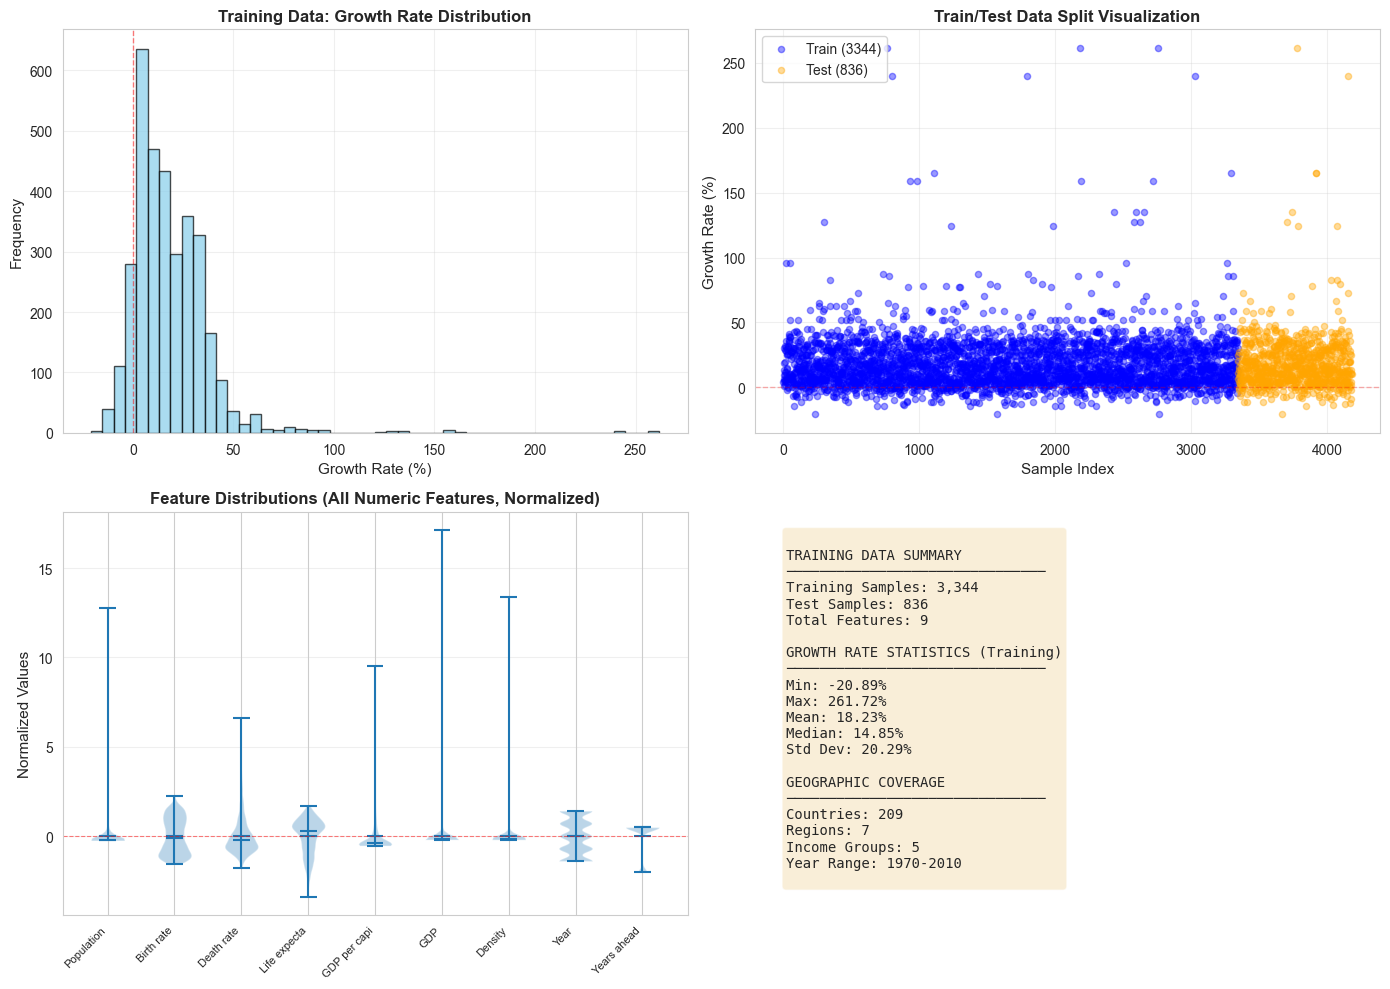


✓ Data visualization saved to '../processed_data/data_visualization.png'


In [6]:
###############################################
# Data Visualization
###############################################

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

print("\n" + "="*70)
print("DATA VISUALIZATION")
print("="*70)

# 1. Target variable distribution and statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Growth rate distribution
axes[0, 0].hist(y_train, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Growth Rate (%)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Training Data: Growth Rate Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero Growth')

# Train vs Test split visualization
axes[0, 1].scatter(range(len(y_train)), y_train, alpha=0.4, s=20, label=f'Train ({len(y_train)})', color='blue')
axes[0, 1].scatter(range(len(y_train), len(y_train) + len(y_test)), y_test, alpha=0.4, s=20, label=f'Test ({len(y_test)})', color='orange')
axes[0, 1].set_xlabel('Sample Index', fontsize=11)
axes[0, 1].set_ylabel('Growth Rate (%)', fontsize=11)
axes[0, 1].set_title('Train/Test Data Split Visualization', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.3)

# Feature distributions - show all numeric features
X_train_display = X_train.copy()
# Select only numeric columns
numeric_cols = X_train_display.select_dtypes(include=[np.number]).columns.tolist()
X_train_numeric = X_train_display[numeric_cols].copy()

# Create a more comprehensive feature distribution visualization
# Use violin plot to show distribution shape
num_features = len(numeric_cols)
if num_features > 0:
    # Normalize for better visualization
    X_train_normalized = (X_train_numeric - X_train_numeric.mean()) / X_train_numeric.std()
    
    # Create violin plot with all features
    parts = axes[1, 0].violinplot(
        [X_train_normalized[col].dropna().values for col in numeric_cols],
        positions=range(num_features),
        showmeans=True,
        showmedians=True
    )
    
    axes[1, 0].set_xticks(range(num_features))
    axes[1, 0].set_xticklabels([col[:12] for col in numeric_cols], rotation=45, ha='right', fontsize=8)
    axes[1, 0].set_ylabel('Normalized Values', fontsize=11)
    axes[1, 0].set_title('Feature Distributions (All Numeric Features, Normalized)', fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')
    axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Data summary statistics
axes[1, 1].axis('off')
summary_text = f"""
TRAINING DATA SUMMARY
───────────────────────────────
Training Samples: {len(y_train):,}
Test Samples: {len(y_test):,}
Total Features: {X_train.shape[1]}

GROWTH RATE STATISTICS (Training)
───────────────────────────────
Min: {y_train.min():.2f}%
Max: {y_train.max():.2f}%
Mean: {y_train.mean():.2f}%
Median: {np.median(y_train):.2f}%
Std Dev: {y_train.std():.2f}%

GEOGRAPHIC COVERAGE
───────────────────────────────
Countries: {meta_train['CCA3'].nunique()}
Regions: {meta_train['Region'].nunique()}
Income Groups: {meta_train['IncomeGroup'].nunique()}
Year Range: {meta_train['Year'].min()}-{meta_train['Year'].max()}
"""
axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../processed_data/data_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Data visualization saved to '../processed_data/data_visualization.png'")


In [7]:
###############################################
# Train Multiple Models
###############################################

print("\n" + "="*70)
print("TRAINING MACHINE LEARNING MODELS")
print("="*70)

# Create preprocessing pipeline (imputation + scaling)
preprocessor = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Dictionary to store models and results
models = {}
results = {}

# Define models to train
model_configs = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

print("\nTraining models with preprocessing pipeline...\n")

for model_name, model in model_configs.items():
    print(f"Training {model_name}...")
    
    # Create pipeline: preprocessing + model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics (RMSE and MAE only)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Store model and results
    models[model_name] = pipeline
    results[model_name] = {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'predictions': y_test_pred,
        'y_test': y_test
    }
    
    print(f"  ✓ {model_name} trained")
    print(f"    - Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"    - Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print()

print("="*70)
print("MODEL TRAINING COMPLETE")
print("="*70)

# Print summary comparison
print("\nMODEL COMPARISON SUMMARY:")
print("-" * 70)
print(f"{'Model':<20} {'Test MAE':<15} {'Test RMSE':<15}")
print("-" * 70)
for model_name in results.keys():
    mae = results[model_name]['test_mae']
    rmse = results[model_name]['test_rmse']
    print(f"{model_name:<20} {mae:<15.2f} {rmse:<15.2f}")
print("-" * 70)

# Identify best model (lowest RMSE)
best_model_name = min(results.keys(), key=lambda x: results[x]['test_rmse'])
print(f"\n🏆 Best Model: {best_model_name} (Test RMSE = {results[best_model_name]['test_rmse']:.2f}, MAE = {results[best_model_name]['test_mae']:.2f})")


TRAINING MACHINE LEARNING MODELS

Training models with preprocessing pipeline...

Training Linear Regression...
  ✓ Linear Regression trained
    - Train RMSE: 16.82, Test RMSE: 18.34
    - Train MAE: 8.23, Test MAE: 8.48

Training Random Forest...
  ✓ Linear Regression trained
    - Train RMSE: 16.82, Test RMSE: 18.34
    - Train MAE: 8.23, Test MAE: 8.48

Training Random Forest...
  ✓ Random Forest trained
    - Train RMSE: 3.80, Test RMSE: 4.62
    - Train MAE: 2.67, Test MAE: 3.20

Training Gradient Boosting...
  ✓ Random Forest trained
    - Train RMSE: 3.80, Test RMSE: 4.62
    - Train MAE: 2.67, Test MAE: 3.20

Training Gradient Boosting...


  ✓ Gradient Boosting trained
    - Train RMSE: 3.86, Test RMSE: 4.46
    - Train MAE: 2.81, Test MAE: 3.18

MODEL TRAINING COMPLETE

MODEL COMPARISON SUMMARY:
----------------------------------------------------------------------
Model                Test MAE        Test RMSE      
----------------------------------------------------------------------
Linear Regression    8.48            18.34          
Random Forest        3.20            4.62           
Gradient Boosting    3.18            4.46           
----------------------------------------------------------------------

🏆 Best Model: Gradient Boosting (Test RMSE = 4.46, MAE = 3.18)



MODEL PERFORMANCE VISUALIZATION


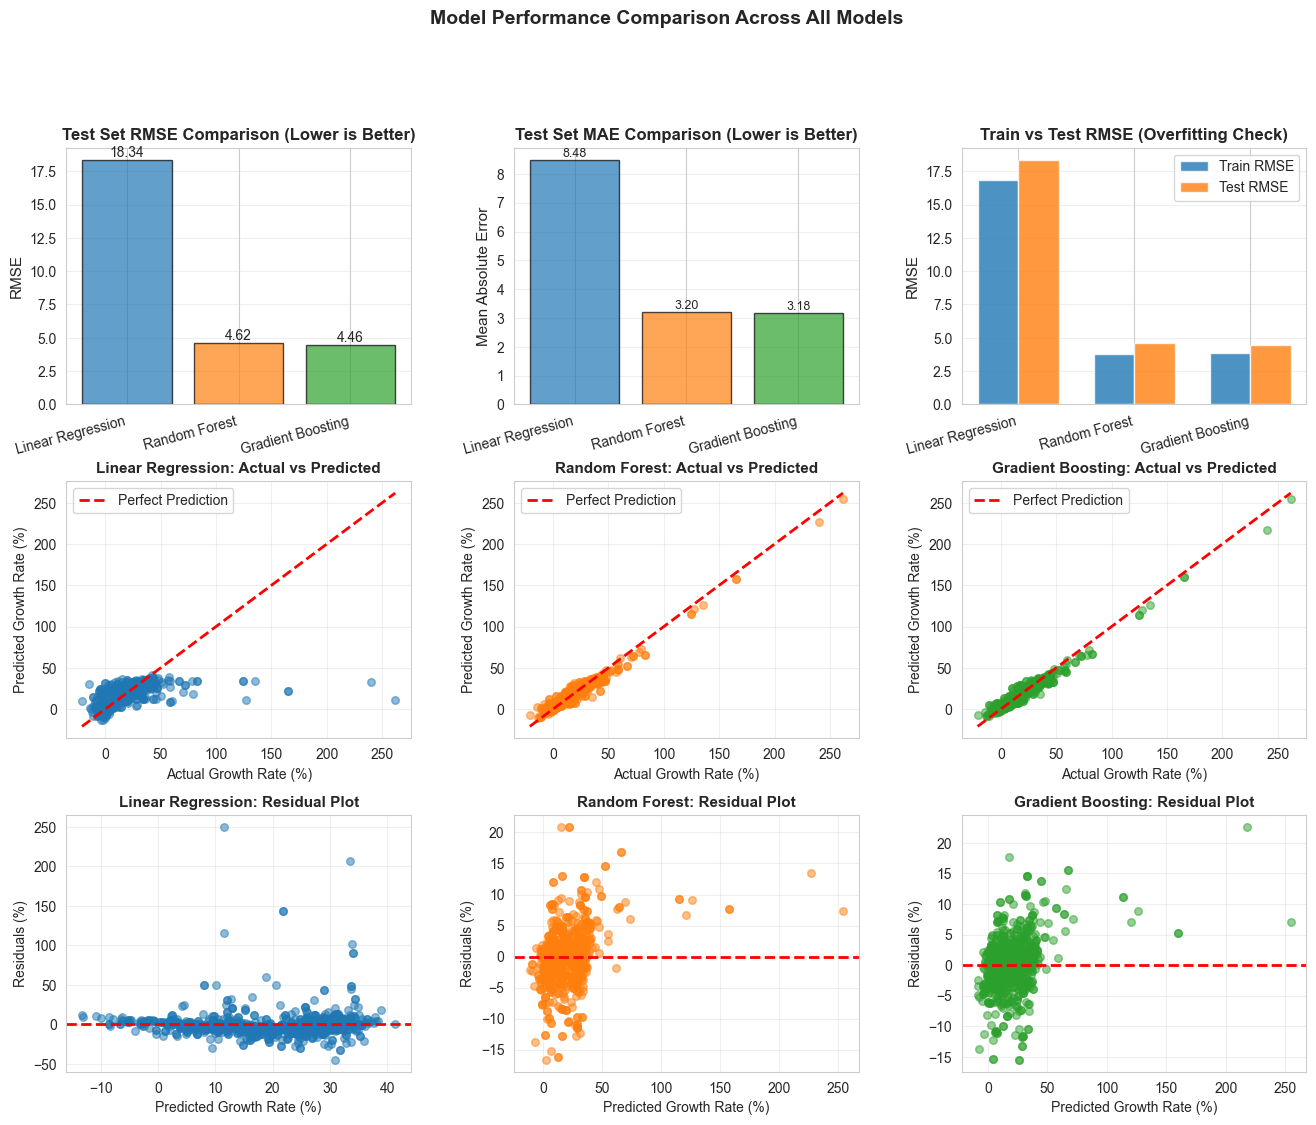

✓ Model performance visualization saved to '../processed_data/model_performance.png'

DETAILED PERFORMANCE METRICS

Linear Regression:
  Train MAE:  8.23%
  Test MAE:   8.48%
  Train RMSE: 16.82%
  Test RMSE:  18.34%
  Mean Residual: 0.33%
  Std Residual:  18.34%

Random Forest:
  Train MAE:  2.67%
  Test MAE:   3.20%
  Train RMSE: 3.80%
  Test RMSE:  4.62%
  Mean Residual: 0.12%
  Std Residual:  4.62%

Gradient Boosting:
  Train MAE:  2.81%
  Test MAE:   3.18%
  Train RMSE: 3.86%
  Test RMSE:  4.46%
  Mean Residual: 0.12%
  Std Residual:  4.46%


In [8]:
###############################################
# Model Visualization - Learning Curves & Performance
###############################################

print("\n" + "="*70)
print("MODEL PERFORMANCE VISUALIZATION")
print("="*70)

# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Color palette for models
colors = {'Linear Regression': '#1f77b4', 'Random Forest': '#ff7f0e', 'Gradient Boosting': '#2ca02c'}
model_names = list(results.keys())

# 1. Model Comparison - Test RMSE scores
ax1 = fig.add_subplot(gs[0, 0])
test_rmse_scores = [results[m]['test_rmse'] for m in model_names]
bars = ax1.bar(model_names, test_rmse_scores, color=[colors[m] for m in model_names], edgecolor='black', alpha=0.7)
ax1.set_ylabel('RMSE', fontsize=11)
ax1.set_title('Test Set RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 2. Model Comparison - Test MAE scores
ax2 = fig.add_subplot(gs[0, 1])
test_mae_scores = [results[m]['test_mae'] for m in model_names]
bars = ax2.bar(model_names, test_mae_scores, color=[colors[m] for m in model_names], edgecolor='black', alpha=0.7)
ax2.set_ylabel('Mean Absolute Error', fontsize=11)
ax2.set_title('Test Set MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 3. Train vs Test RMSE - all models
ax3 = fig.add_subplot(gs[0, 2])
x_pos = np.arange(len(model_names))
width = 0.35
train_rmse = [results[m]['train_rmse'] for m in model_names]
test_rmse = [results[m]['test_rmse'] for m in model_names]
ax3.bar(x_pos - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
ax3.bar(x_pos + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
ax3.set_ylabel('RMSE', fontsize=11)
ax3.set_title('Train vs Test RMSE (Overfitting Check)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(model_names, rotation=15, ha='right')
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# 4-6. Prediction Accuracy plots for each model (Actual vs Predicted)
for idx, model_name in enumerate(model_names):
    ax = fig.add_subplot(gs[1, idx])
    y_pred = results[model_name]['predictions']
    y_actual = results[model_name]['y_test']
    
    # Scatter plot: Actual vs Predicted
    ax.scatter(y_actual, y_pred, alpha=0.5, s=30, color=colors[model_name])
    
    # Perfect prediction line
    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Growth Rate (%)', fontsize=10)
    ax.set_ylabel('Predicted Growth Rate (%)', fontsize=10)
    ax.set_title(f'{model_name}: Actual vs Predicted', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

# 7-9. Residual plots for each model
for idx, model_name in enumerate(model_names):
    ax = fig.add_subplot(gs[2, idx])
    y_pred = results[model_name]['predictions']
    y_actual = results[model_name]['y_test']
    residuals = y_actual - y_pred
    
    # Residual plot
    ax.scatter(y_pred, residuals, alpha=0.5, s=30, color=colors[model_name])
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel('Predicted Growth Rate (%)', fontsize=10)
    ax.set_ylabel('Residuals (%)', fontsize=10)
    ax.set_title(f'{model_name}: Residual Plot', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)

plt.suptitle('Model Performance Comparison Across All Models', fontsize=14, fontweight='bold', y=0.995)
plt.savefig('../processed_data/model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Model performance visualization saved to '../processed_data/model_performance.png'")

# Print detailed performance metrics table
print("\n" + "="*70)
print("DETAILED PERFORMANCE METRICS")
print("="*70)
for model_name in model_names:
    print(f"\n{model_name}:")
    print(f"  Train MAE:  {results[model_name]['train_mae']:.2f}%")
    print(f"  Test MAE:   {results[model_name]['test_mae']:.2f}%")
    print(f"  Train RMSE: {results[model_name]['train_rmse']:.2f}%")
    print(f"  Test RMSE:  {results[model_name]['test_rmse']:.2f}%")
    
    # Calculate residual statistics
    y_pred = results[model_name]['predictions']
    y_actual = results[model_name]['y_test']
    residuals = y_actual - y_pred
    print(f"  Mean Residual: {np.mean(residuals):.2f}%")
    print(f"  Std Residual:  {np.std(residuals):.2f}%")



LEARNING CURVES & TRAINING PROGRESS

Computing learning curves for Gradient Boosting...
Training set for curve: 3344 samples
Test set for curve: 836 samples
Computing staged predictions...
Computing staged predictions...


Learning iterations: 100%|██████████| 100/100 [00:00<00:00, 4266.62it/s]


Computing cross-validation learning curves...


Models: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]



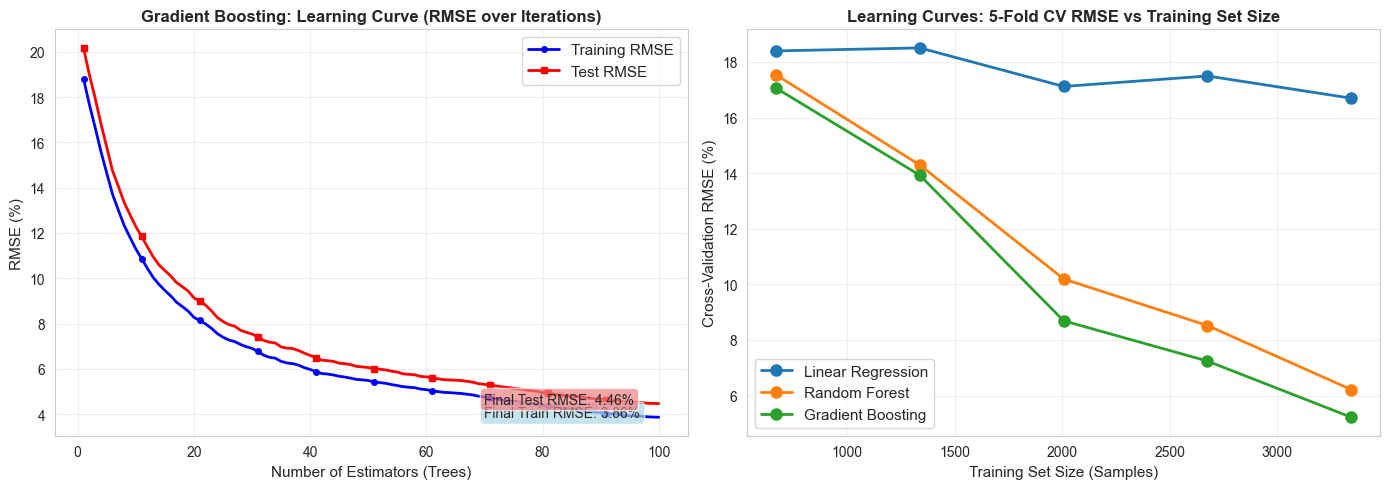

✓ Learning curves saved to '../processed_data/learning_curves.png'

OVERFITTING ANALYSIS

Linear Regression:
  Train RMSE: 16.82%, Test RMSE: 18.34%
  Overfitting Gap: 1.52% (9.0% increase)
  ✓ Excellent - minimal overfitting

Random Forest:
  Train RMSE: 3.80%, Test RMSE: 4.62%
  Overfitting Gap: 0.82% (21.5% increase)
  ⚠ Moderate - some overfitting present

Gradient Boosting:
  Train RMSE: 3.86%, Test RMSE: 4.46%
  Overfitting Gap: 0.61% (15.7% increase)
  ✓ Good - acceptable overfitting


In [9]:
###############################################
# Learning Curves - Training Progress Analysis
###############################################

from tqdm import tqdm

print("\n" + "="*70)
print("LEARNING CURVES & TRAINING PROGRESS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Train Gradient Boosting with staged predictions to get learning curve
print("\nComputing learning curves for Gradient Boosting...")

# Use preprocessor from pipeline to transform data
best_model_pipeline = models['Gradient Boosting']
preprocessor = best_model_pipeline.named_steps['preprocessor']

# Preprocess the data
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"Training set for curve: {X_train_preprocessed.shape[0]} samples")
print(f"Test set for curve: {X_test_preprocessed.shape[0]} samples")

# Train a fresh GB model to get staged predictions
gb_model_for_curve = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model_for_curve.fit(X_train_preprocessed, y_train)

train_losses = []
test_losses = []
estimators = []

print("Computing staged predictions...")
for i, (y_train_pred, y_test_pred) in enumerate(tqdm(
    zip(
        gb_model_for_curve.staged_predict(X_train_preprocessed),
        gb_model_for_curve.staged_predict(X_test_preprocessed)
    ),
    total=100,
    desc="Learning iterations"
)):
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_losses.append(np.sqrt(train_mse))  # RMSE
    test_losses.append(np.sqrt(test_mse))     # RMSE
    estimators.append(i + 1)

# Plot learning curve
axes[0].plot(estimators, train_losses, 'b-', linewidth=2, label='Training RMSE', marker='o', markersize=4, markevery=10)
axes[0].plot(estimators, test_losses, 'r-', linewidth=2, label='Test RMSE', marker='s', markersize=4, markevery=10)
axes[0].set_xlabel('Number of Estimators (Trees)', fontsize=11)
axes[0].set_ylabel('RMSE (%)', fontsize=11)
axes[0].set_title('Gradient Boosting: Learning Curve (RMSE over Iterations)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Add annotation for final values
axes[0].text(len(estimators)*0.7, train_losses[-1], f'Final Train RMSE: {train_losses[-1]:.2f}%',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7), fontsize=10)
axes[0].text(len(estimators)*0.7, test_losses[-1], f'Final Test RMSE: {test_losses[-1]:.2f}%',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7), fontsize=10)

# 2. Cross-validation learning curves with RMSE
print("Computing cross-validation learning curves...")

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

ax = axes[1]
train_sizes = np.linspace(0.2, 1.0, 5)
train_size_counts = (train_sizes * len(X_train)).astype(int)

colors_cv = {'Linear Regression': '#1f77b4', 'Random Forest': '#ff7f0e', 'Gradient Boosting': '#2ca02c'}

# Create RMSE scorer for cross-validation (negative because sklearn maximizes scores)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), 
                          greater_is_better=False)

for model_name in tqdm(model_names, desc="Models"):
    cv_rmse_scores = []
    
    model_obj = models[model_name]
    
    for train_size in tqdm(train_sizes, desc=f"  {model_name} - train sizes", leave=False):
        # Sample training data
        indices = np.random.RandomState(42).choice(len(X_train), size=int(train_size * len(X_train)), replace=False)
        X_train_sample = X_train.iloc[indices]
        y_train_sample = y_train[indices]
        
        # Perform 5-fold cross-validation with RMSE
        cv_scores = cross_val_score(model_obj, X_train_sample, y_train_sample, 
                                    cv=5, scoring=rmse_scorer, n_jobs=-1)
        
        # Convert negative RMSE back to positive and take mean
        mean_cv_rmse = -cv_scores.mean()
        cv_rmse_scores.append(mean_cv_rmse)
    
    ax.plot(train_size_counts, cv_rmse_scores, 'o-', linewidth=2, 
           label=f'{model_name}', color=colors_cv[model_name], markersize=8)

ax.set_xlabel('Training Set Size (Samples)', fontsize=11)
ax.set_ylabel('Cross-Validation RMSE (%)', fontsize=11)
ax.set_title('Learning Curves: 5-Fold CV RMSE vs Training Set Size', fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../processed_data/learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Learning curves saved to '../processed_data/learning_curves.png'")

# Print insights about overfitting
print("\n" + "="*70)
print("OVERFITTING ANALYSIS")
print("="*70)
for model_name in model_names:
    train_rmse = results[model_name]['train_rmse']
    test_rmse = results[model_name]['test_rmse']
    gap = test_rmse - train_rmse
    gap_pct = (gap / train_rmse) * 100 if train_rmse > 0 else 0
    
    print(f"\n{model_name}:")
    print(f"  Train RMSE: {train_rmse:.2f}%, Test RMSE: {test_rmse:.2f}%")
    print(f"  Overfitting Gap: {gap:.2f}% ({gap_pct:.1f}% increase)")
    
    if gap_pct < 10:
        print(f"  ✓ Excellent - minimal overfitting")
    elif gap_pct < 20:
        print(f"  ✓ Good - acceptable overfitting")
    elif gap_pct < 50:
        print(f"  ⚠ Moderate - some overfitting present")
    else:
        print(f"  ✗ High - significant overfitting")


/Users/anders/Library/CloudStorage/OneDrive-NTNU/Berkeley/2025Fall/Data Mining/project_final/Prediction-Population-Growth/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



FEATURE IMPORTANCE ANALYSIS (SHAP VALUES)

Computing SHAP values for Gradient Boosting model...
This may take a moment...
(Analyzing which features most influence growth rate predictions)



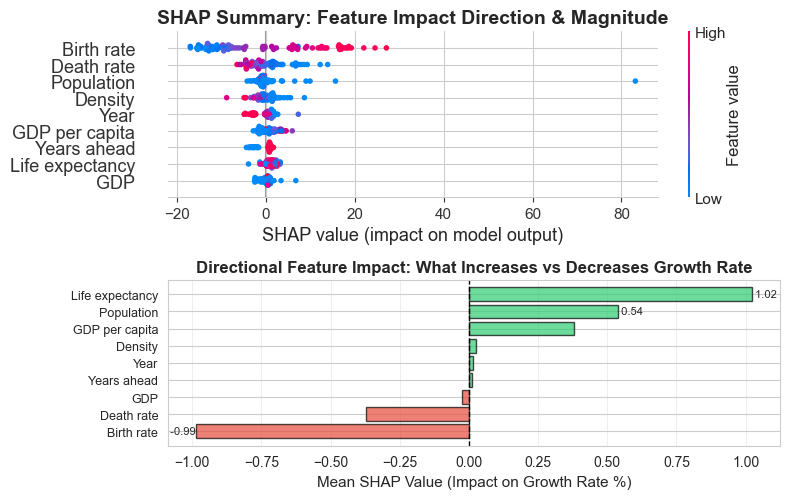

✓ SHAP importance plot saved to '../processed_data/shap_importance.png'

DIRECTIONAL FEATURE IMPACTS ON GROWTH RATE

🔼 FEATURES THAT INCREASE GROWTH RATE (Positive Mean SHAP):
----------------------------------------------------------------------
  Life expectancy                : +  1.0237 (pushes predictions UP)
  Population                     : +  0.5402 (pushes predictions UP)
  GDP per capita                 : +  0.3798 (pushes predictions UP)
  Density                        : +  0.0273 (pushes predictions UP)
  Year                           : +  0.0158 (pushes predictions UP)
  Years ahead                    : +  0.0128 (pushes predictions UP)

🔽 FEATURES THAT DECREASE GROWTH RATE (Negative Mean SHAP):
----------------------------------------------------------------------
  GDP                            :  -0.0262 (pushes predictions DOWN)
  Death rate                     :  -0.3736 (pushes predictions DOWN)
  Birth rate                     :  -0.9870 (pushes predictions DOWN

In [10]:
###############################################
# SHAP Values - Feature Importance Analysis
###############################################
import shap

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS (SHAP VALUES)")
print("="*70)


# Use the best performing model (Gradient Boosting) for SHAP analysis
best_model_pipeline = models['Gradient Boosting']
# Extract the actual model from the pipeline
best_model = best_model_pipeline.named_steps['model']

print("\nComputing SHAP values for Gradient Boosting model...")
print("This may take a moment...")
print("(Analyzing which features most influence growth rate predictions)\n")

# Create SHAP explainer
# Use a sample of training data for faster computation
sample_size = min(100, len(X_train))
sample_idx = np.random.RandomState(42).choice(len(X_train), size=sample_size, replace=False)
X_sample = X_train.iloc[sample_idx]

# Preprocess the sample data using the pipeline's preprocessor
X_sample_preprocessed = best_model_pipeline.named_steps['preprocessor'].transform(X_sample)
X_sample_preprocessed_df = pd.DataFrame(X_sample_preprocessed, columns=X_sample.columns)

# TreeExplainer is most efficient for tree-based models
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample_preprocessed_df)

# Create SHAP visualizations
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 1. Summary plot (dot plot) - shows distribution and direction of SHAP values
plt.sca(axes[0])
shap.summary_plot(shap_values, X_sample_preprocessed_df, show=False)
axes[0].set_title('SHAP Summary: Feature Impact Direction & Magnitude', fontsize=14, fontweight='bold')

# 2. Mean SHAP values (directional) - what pushes predictions up vs down
plt.sca(axes[1])
mean_shap = shap_values.mean(axis=0)
feature_names = X_sample_preprocessed_df.columns

# Sort by mean SHAP value
sorted_idx = np.argsort(mean_shap)
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_values = mean_shap[sorted_idx]

# Create horizontal bar chart with colors
colors_bar = ['#e74c3c' if val < 0 else '#2ecc71' for val in sorted_values]
y_pos = np.arange(len(sorted_features))

axes[1].barh(y_pos, sorted_values, color=colors_bar, edgecolor='black', alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(sorted_features, fontsize=9)
axes[1].set_xlabel('Mean SHAP Value (Impact on Growth Rate %)', fontsize=11)
axes[1].set_title('Directional Feature Impact: What Increases vs Decreases Growth Rate', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.3, axis='x')

# Add text annotations for extreme values
for i, (feat, val) in enumerate(zip(sorted_features, sorted_values)):
    if abs(val) > 0.5:  # Only annotate significant features
        axes[1].text(val, i, f' {val:.2f}', va='center', 
                    ha='left' if val > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig('../processed_data/shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ SHAP importance plot saved to '../processed_data/shap_importance.png'")

# Print directional feature impacts
print("\n" + "="*70)
print("DIRECTIONAL FEATURE IMPACTS ON GROWTH RATE")
print("="*70)

# Calculate mean SHAP values (directional)
mean_shap_values = shap_values.mean(axis=0)
feature_impact_df = pd.DataFrame({
    'Feature': X_sample_preprocessed_df.columns,
    'Mean SHAP': mean_shap_values,
    'Impact': ['Increases Growth' if x > 0 else 'Decreases Growth' for x in mean_shap_values]
}).sort_values('Mean SHAP', ascending=False)

print("\n🔼 FEATURES THAT INCREASE GROWTH RATE (Positive Mean SHAP):")
print("-" * 70)
positive_features = feature_impact_df[feature_impact_df['Mean SHAP'] > 0]
if len(positive_features) > 0:
    for idx, row in positive_features.iterrows():
        print(f"  {row['Feature']:30s} : +{row['Mean SHAP']:8.4f} (pushes predictions UP)")
else:
    print("  None")

print("\n🔽 FEATURES THAT DECREASE GROWTH RATE (Negative Mean SHAP):")
print("-" * 70)
negative_features = feature_impact_df[feature_impact_df['Mean SHAP'] < 0]
if len(negative_features) > 0:
    for idx, row in negative_features.iterrows():
        print(f"  {row['Feature']:30s} : {row['Mean SHAP']:8.4f} (pushes predictions DOWN)")
else:
    print("  None")

print("\n" + "="*70)
print("SHAP VALUE INTERPRETATION")
print("="*70)
print("""
SHAP (SHapley Additive exPlanations) values show directional feature impacts:

🔼 POSITIVE Mean SHAP = Feature pushes growth rate predictions UP on average
    Example: If "Birth rate" has +2.5, it increases predicted growth rates

🔽 NEGATIVE Mean SHAP = Feature pulls growth rate predictions DOWN on average
    Example: If "Death rate" has -1.8, it decreases predicted growth rates

• The MAGNITUDE shows HOW STRONG the push/pull effect is
• In the dot plot: Red = high feature values, Blue = low feature values
• Dots to the RIGHT increase prediction, dots to the LEFT decrease it

This reveals what DRIVES population growth vs what SLOWS IT DOWN according to the model.
""")




PREDICTING 2025 POPULATION FROM 2015 DATA
Available years in merged data: [np.int64(1970), np.int64(1980), np.int64(1990), np.int64(2000), np.int64(2010), np.int64(2015)]
Latest year: 2015

Countries with 2015 data: 209
Features prepared for 209 countries

Training columns: ['Population', 'Birth rate', 'Death rate', 'Life expectancy', 'GDP per capita', 'GDP', 'Density', 'Year', 'Years ahead']
X_2015 columns before reorder: ['Population', 'Birth rate', 'Death rate', 'Life expectancy', 'GDP per capita', 'GDP', 'Density', 'Year', 'Years ahead']
X_2015 columns after reorder: ['Population', 'Birth rate', 'Death rate', 'Life expectancy', 'GDP per capita', 'GDP', 'Density', 'Year', 'Years ahead']

✓ Predictions generated for 2025
  Average predicted growth rate: 11.79%
  Growth rate range: -5.82% to 44.43%

✓ Predictions saved to '../processed_data/population_predictions_2025.csv'


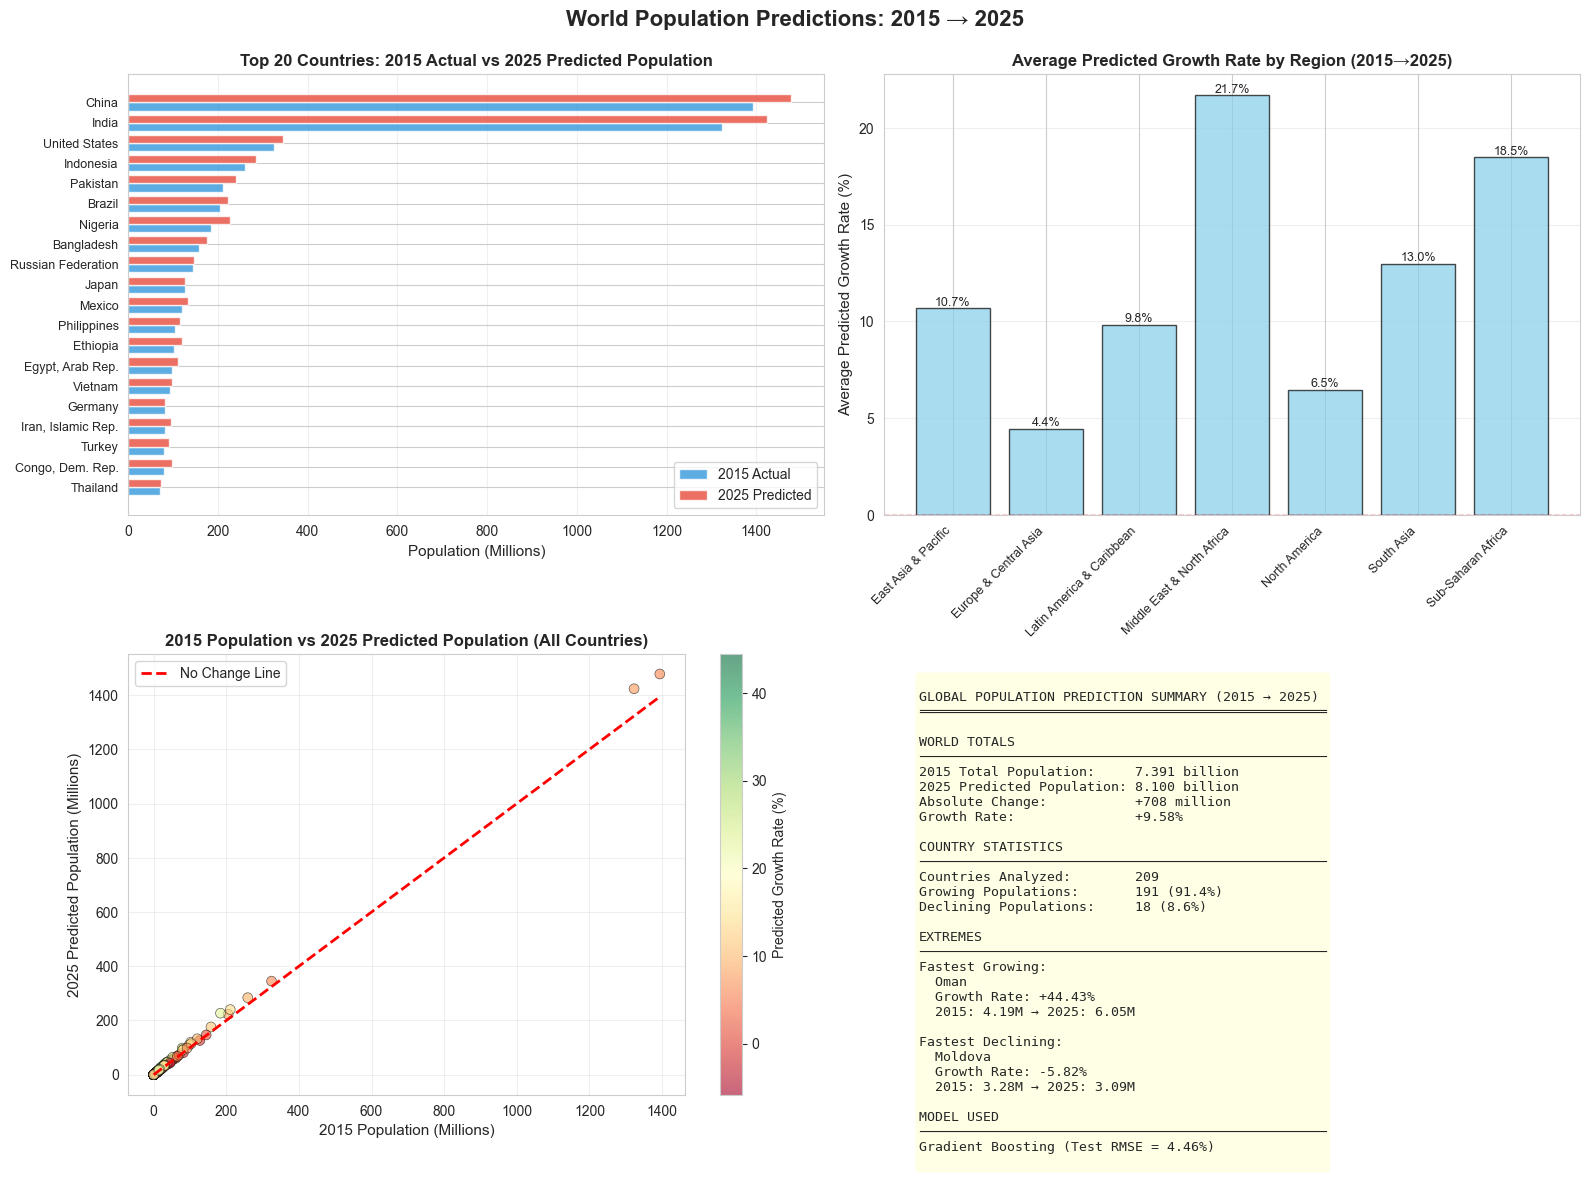


✓ Visualization saved to '../processed_data/population_prediction_2015_2025.png'

TOP 10 COUNTRIES BY 2015 POPULATION - 2025 PREDICTIONS

Rank  Country                   2015 (M)     2025 (M)     Growth %  
----------------------------------------------------------------------
1     China                        1393.72     1477.75      6.03%
2     India                        1322.87     1423.33      7.59%
3     United States                 324.61      345.11      6.32%
4     Indonesia                     259.09      284.10      9.65%
5     Pakistan                      210.97      240.11     13.81%
6     Brazil                        205.19      222.65      8.51%
7     Nigeria                       184.00      226.94     23.34%
8     Bangladesh                    157.83      176.06     11.55%
9     Russian Federation            144.67      146.77      1.45%
10    Japan                         127.25      126.29     -0.75%


In [11]:
###############################################
# 2015 vs 2025 Population Prediction
###############################################

print("\n" + "="*70)
print("PREDICTING 2025 POPULATION FROM 2015 DATA")
print("="*70)

# Check what years are available in the merged data
print(f"Available years in merged data: {sorted(df_merged['Year'].unique())}")
print(f"Latest year: {df_merged['Year'].max()}")

# Use 2015 data (latest available) to predict 2025 (10 years ahead)
df_merged_2015 = df_merged[df_merged['Year'] == 2015].copy()

print(f"\nCountries with 2015 data: {len(df_merged_2015)}")

# Prepare features for 2015 to predict 2025 (10 years ahead)
X_2015_list = []
meta_2015_list = []

for idx, row in df_merged_2015.iterrows():
    feature_row = {
        'Population': row['Population'],
        'Birth rate': row.get('Birth rate, crude (per 1,000 people)', np.nan),
        'Death rate': row.get('Death rate, crude (per 1,000 people)', np.nan),
        'Life expectancy': row.get('Life expectancy at birth (years)', np.nan),
        'GDP per capita': row.get('GDP per capita (USD)', np.nan),
        'GDP': row.get('GDP (USD)', np.nan),
        'Density': row.get('Population density (people per sq. km of land area)', np.nan),
        'Year': 2015,
        'Years ahead': 10  # Predicting 10 years into the future
    }
    
    X_2015_list.append(feature_row)
    meta_2015_list.append({
        'Country Name': row['Country Name'],
        'CCA3': row['CCA3'],
        'Region': row.get('Region', 'Unknown'),
        'Population_2015': row['Population']
    })

X_2015 = pd.DataFrame(X_2015_list)
meta_2015 = pd.DataFrame(meta_2015_list)

print(f"Features prepared for {len(X_2015)} countries")

# Ensure X_2015 has the same columns as training data in the same order
# Get the column order from the training data
training_columns = X_train.columns.tolist()
print(f"\nTraining columns: {training_columns}")
print(f"X_2015 columns before reorder: {X_2015.columns.tolist()}")

# Reorder X_2015 to match training data columns
X_2015 = X_2015[training_columns]
print(f"X_2015 columns after reorder: {X_2015.columns.tolist()}")

# Use the best model (Gradient Boosting) to predict growth rate for 2025
best_model = models['Gradient Boosting']
predicted_growth_rates = best_model.predict(X_2015)

# Calculate predicted 2025 population from growth rate
# Growth rate = ((future - current) / current) * 100
# Therefore: future = current * (1 + growth_rate/100)
meta_2015['Predicted_Growth_Rate_2025'] = predicted_growth_rates
meta_2015['Predicted_Population_2025'] = meta_2015['Population_2015'] * (1 + predicted_growth_rates / 100)

print(f"\n✓ Predictions generated for 2025")
print(f"  Average predicted growth rate: {predicted_growth_rates.mean():.2f}%")
print(f"  Growth rate range: {predicted_growth_rates.min():.2f}% to {predicted_growth_rates.max():.2f}%")

# Save predictions
meta_2015.to_csv('../processed_data/population_predictions_2025.csv', index=False)
print(f"\n✓ Predictions saved to '../processed_data/population_predictions_2025.csv'")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 20 countries by 2015 population - comparing 2015 vs predicted 2025
top_20 = meta_2015.nlargest(20, 'Population_2015').sort_values('Population_2015', ascending=True)
y_pos = np.arange(len(top_20))

ax1 = axes[0, 0]
ax1.barh(y_pos - 0.2, top_20['Population_2015'] / 1e6, 0.4, label='2015 Actual', color='#3498db', alpha=0.8)
ax1.barh(y_pos + 0.2, top_20['Predicted_Population_2025'] / 1e6, 0.4, label='2025 Predicted', color='#e74c3c', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_20['Country Name'], fontsize=9)
ax1.set_xlabel('Population (Millions)', fontsize=11)
ax1.set_title('Top 20 Countries: 2015 Actual vs 2025 Predicted Population', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3, axis='x')

# 2. World map style - growth rate by region
ax2 = axes[0, 1]
regions = meta_2015.groupby('Region').agg({
    'Population_2015': 'sum',
    'Predicted_Population_2025': 'sum',
    'Predicted_Growth_Rate_2025': 'mean'
}).reset_index()
regions['Absolute_Growth'] = regions['Predicted_Population_2025'] - regions['Population_2015']

x_pos_region = np.arange(len(regions))
bars = ax2.bar(x_pos_region, regions['Predicted_Growth_Rate_2025'], color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_xticks(x_pos_region)
ax2.set_xticklabels(regions['Region'], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Average Predicted Growth Rate (%)', fontsize=11)
ax2.set_title('Average Predicted Growth Rate by Region (2015→2025)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)

for bar, val in zip(bars, regions['Predicted_Growth_Rate_2025']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.1f}%', ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

# 3. Scatter plot - 2015 vs 2025 population
ax3 = axes[1, 0]
scatter = ax3.scatter(meta_2015['Population_2015'] / 1e6, 
                     meta_2015['Predicted_Population_2025'] / 1e6,
                     c=meta_2015['Predicted_Growth_Rate_2025'],
                     cmap='RdYlGn', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax3.plot([0, meta_2015['Population_2015'].max() / 1e6], 
         [0, meta_2015['Population_2015'].max() / 1e6], 
         'r--', linewidth=2, label='No Change Line')
ax3.set_xlabel('2015 Population (Millions)', fontsize=11)
ax3.set_ylabel('2025 Predicted Population (Millions)', fontsize=11)
ax3.set_title('2015 Population vs 2025 Predicted Population (All Countries)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Predicted Growth Rate (%)', fontsize=10)

# 4. Summary statistics table
ax4 = axes[1, 1]
ax4.axis('off')

total_2015 = meta_2015['Population_2015'].sum()
total_2025 = meta_2015['Predicted_Population_2025'].sum()
total_growth = ((total_2025 - total_2015) / total_2015) * 100

countries_growing = (meta_2015['Predicted_Growth_Rate_2025'] > 0).sum()
countries_declining = (meta_2015['Predicted_Growth_Rate_2025'] < 0).sum()

fastest_growing = meta_2015.nlargest(1, 'Predicted_Growth_Rate_2025').iloc[0]
fastest_declining = meta_2015.nsmallest(1, 'Predicted_Growth_Rate_2025').iloc[0]

summary_text = f"""
GLOBAL POPULATION PREDICTION SUMMARY (2015 → 2025)
═══════════════════════════════════════════════════

WORLD TOTALS
───────────────────────────────────────────────────
2015 Total Population:     {total_2015/1e9:.3f} billion
2025 Predicted Population: {total_2025/1e9:.3f} billion
Absolute Change:           {(total_2025-total_2015)/1e6:+,.0f} million
Growth Rate:               {total_growth:+.2f}%

COUNTRY STATISTICS
───────────────────────────────────────────────────
Countries Analyzed:        {len(meta_2015)}
Growing Populations:       {countries_growing} ({countries_growing/len(meta_2015)*100:.1f}%)
Declining Populations:     {countries_declining} ({countries_declining/len(meta_2015)*100:.1f}%)

EXTREMES
───────────────────────────────────────────────────
Fastest Growing:
  {fastest_growing['Country Name'][:30]}
  Growth Rate: {fastest_growing['Predicted_Growth_Rate_2025']:+.2f}%
  2015: {fastest_growing['Population_2015']/1e6:.2f}M → 2025: {fastest_growing['Predicted_Population_2025']/1e6:.2f}M

Fastest Declining:
  {fastest_declining['Country Name'][:30]}
  Growth Rate: {fastest_declining['Predicted_Growth_Rate_2025']:+.2f}%
  2015: {fastest_declining['Population_2015']/1e6:.2f}M → 2025: {fastest_declining['Predicted_Population_2025']/1e6:.2f}M

MODEL USED
───────────────────────────────────────────────────
Gradient Boosting (Test RMSE = {results['Gradient Boosting']['test_rmse']:.2f}%)
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=9.5, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.suptitle('World Population Predictions: 2015 → 2025', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../processed_data/population_prediction_2015_2025.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to '../processed_data/population_prediction_2015_2025.png'")

# Print top 10 predictions
print("\n" + "="*70)
print("TOP 10 COUNTRIES BY 2015 POPULATION - 2025 PREDICTIONS")
print("="*70)
top_10 = meta_2015.nlargest(10, 'Population_2015')
print(f"\n{'Rank':<5} {'Country':<25} {'2015 (M)':<12} {'2025 (M)':<12} {'Growth %':<10}")
print("-" * 70)
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"{i:<5} {row['Country Name'][:24]:<25} {row['Population_2015']/1e6:>10.2f}  {row['Predicted_Population_2025']/1e6:>10.2f}  {row['Predicted_Growth_Rate_2025']:>8.2f}%")
